# MVA2018 - MP1 - Classification and Regression

by Dora Linda Kocsis
09-02-2018

# 1/ Loading Required Libraries, Given Functions

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.patches as patches

#used for Exercise 2
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import optimizers

#used for Exercise 4-5
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout

#used for Bonus Question
from keras.layers import Input, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard

In [73]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

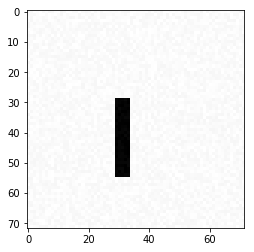

In [74]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72,72), cmap='gray')

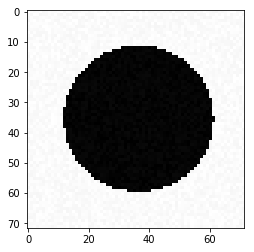

In [75]:
im = generate_a_disk(10)
plt.imshow(im.reshape(72,72), cmap='gray')

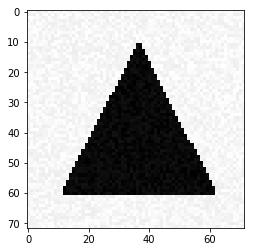

In [76]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72,72), cmap='gray')

In [77]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [78]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

# 2/ Simple Classification

Build and train a linear classifier in Keras to classify a image into one of the three possible
categories (i.e. rectangle, disk, triangle). Try using the stochastic gradient descent optimizer, then
the Adam optimizer.

In [79]:
batch_size = 32
nb_classes = 3
nb_epoch = 10

lr_to_test = [0.0001, 0.001, 0.01, 0.1]

In [80]:
#Generate training set
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = to_categorical(Y_train, num_classes=nb_classes)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [81]:
n_cols = X_train.shape[1]

def simple_classification_model():
    model = Sequential()
    #model.add(Dense(300, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(nb_classes, activation='softmax', input_shape=(n_cols,)))
    
    return(model)

## 2.1/ Simple Classification - Optimizer: Stochastic Gradient Descent

In [82]:
for lr in lr_to_test:
    model_1 = simple_classification_model()
    sgd = optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=False)
    model_1.compile(optimizer=sgd, 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])
    early_stopping = EarlyStopping(patience=3)
    model_1.fit(X_train, Y_train, 
                batch_size=batch_size, 
                validation_split=0.3, 
                epochs=nb_epoch,
                verbose=1, 
                callbacks=[early_stopping])
    score = model_1.evaluate(X_train, Y_train, verbose=0)
    print('Train score:', score[0])
    print('Train accuracy:', score[1])

Train on 210 samples, validate on 90 samples
Epoch 1/10
210/210 [==============================] - 1s 3ms/step - loss: 1.8537 - acc: 0.3000 - val_loss: 1.5503 - val_acc: 0.2889
Epoch 2/10
210/210 [==============================] - 0s 158us/step - loss: 1.6062 - acc: 0.3429 - val_loss: 1.7789 - val_acc: 0.3333
Epoch 3/10
210/210 [==============================] - 0s 153us/step - loss: 1.2082 - acc: 0.4667 - val_loss: 1.0533 - val_acc: 0.4556
Epoch 4/10
210/210 [==============================] - 0s 143us/step - loss: 1.0702 - acc: 0.4095 - val_loss: 0.9623 - val_acc: 0.6000
Epoch 5/10
210/210 [==============================] - 0s 162us/step - loss: 0.9101 - acc: 0.5667 - val_loss: 1.0119 - val_acc: 0.5000
Epoch 6/10
210/210 [==============================] - 0s 143us/step - loss: 0.8764 - acc: 0.6095 - val_loss: 0.8689 - val_acc: 0.5556
Epoch 7/10
210/210 [==============================] - 0s 162us/step - loss: 0.8255 - acc: 0.6143 - val_loss: 0.8590 - val_acc: 0.6000
Epoch 8/10
210/210 

## 2.1/ Simple Classification - Optimizer: Adam

In [83]:
for lr in lr_to_test:
    model_2 = simple_classification_model()
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model_2.compile(optimizer=adam, 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])
    early_stopping = EarlyStopping(patience=3)
    model_2.fit(X_train, Y_train, 
                batch_size=batch_size, 
                validation_split=0.3, 
                epochs=nb_epoch,
                verbose=1, 
                callbacks=[early_stopping])
    score = model_2.evaluate(X_train, Y_train, verbose=0)
    print('Train score:', score[0])
    print('Train accuracy:', score[1])

Train on 210 samples, validate on 90 samples
Epoch 1/10
210/210 [==============================] - 1s 5ms/step - loss: 1.2042 - acc: 0.3381 - val_loss: 1.1375 - val_acc: 0.4222
Epoch 2/10
210/210 [==============================] - 0s 172us/step - loss: 1.0433 - acc: 0.4571 - val_loss: 1.0175 - val_acc: 0.4556
Epoch 3/10
210/210 [==============================] - 0s 196us/step - loss: 0.9722 - acc: 0.5000 - val_loss: 0.9502 - val_acc: 0.5556
Epoch 4/10
210/210 [==============================] - 0s 182us/step - loss: 0.9025 - acc: 0.6048 - val_loss: 0.9330 - val_acc: 0.5333
Epoch 5/10
210/210 [==============================] - 0s 182us/step - loss: 0.8511 - acc: 0.6429 - val_loss: 0.8459 - val_acc: 0.5333
Epoch 6/10
210/210 [==============================] - 0s 205us/step - loss: 0.8006 - acc: 0.6238 - val_loss: 0.8218 - val_acc: 0.5778
Epoch 7/10
210/210 [==============================] - 0s 182us/step - loss: 0.7505 - acc: 0.6429 - val_loss: 0.7717 - val_acc: 0.5556
Epoch 8/10
210/210 

### Using Best Performing Learning Rate

In [84]:
model_sgd = simple_classification_model()
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=False)
model_sgd.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model_sgd_training = model_sgd.fit(X_train, Y_train, batch_size=32, validation_split=0.3, epochs=10, verbose=1)

model_adam = simple_classification_model()
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_adam.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_adam_training = model_adam.fit(X_train, Y_train, batch_size=32, validation_split=0.3, epochs=10, verbose=1)

Train on 210 samples, validate on 90 samples
Epoch 1/10
210/210 [==============================] - 1s 5ms/step - loss: 1.5638 - acc: 0.2714 - val_loss: 1.0088 - val_acc: 0.5778
Epoch 2/10
210/210 [==============================] - 0s 205us/step - loss: 0.9507 - acc: 0.6048 - val_loss: 1.1220 - val_acc: 0.5222
Epoch 3/10
210/210 [==============================] - 0s 167us/step - loss: 0.8186 - acc: 0.6286 - val_loss: 0.8927 - val_acc: 0.5778
Epoch 4/10
210/210 [==============================] - 0s 182us/step - loss: 0.6988 - acc: 0.7143 - val_loss: 0.9533 - val_acc: 0.7000
Epoch 5/10
210/210 [==============================] - 0s 177us/step - loss: 0.6160 - acc: 0.7381 - val_loss: 0.7232 - val_acc: 0.7333
Epoch 6/10
210/210 [==============================] - 0s 158us/step - loss: 0.5143 - acc: 0.7714 - val_loss: 0.6470 - val_acc: 0.6889
Epoch 7/10
210/210 [==============================] - 0s 239us/step - loss: 0.3918 - acc: 0.8190 - val_loss: 0.4517 - val_acc: 0.7111
Epoch 8/10
210/210 

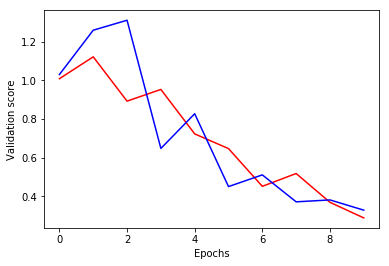

In [85]:
plt.plot(model_sgd_training.history['val_loss'], 'r', model_adam_training.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

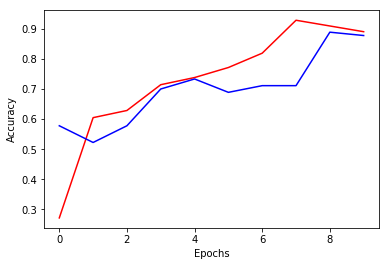

In [86]:
plt.plot(model_sgd_training.history['acc'], 'r', model_sgd_training.history['val_acc'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

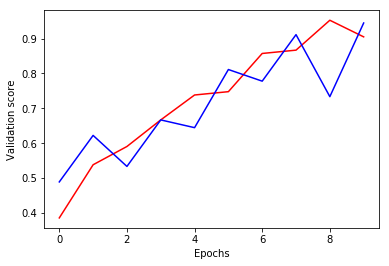

In [87]:
plt.plot(model_adam_training.history['acc'], 'r', model_adam_training.history['val_acc'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

### Model Performance - Test

In [88]:
X_test_sgd = generate_a_disk()
X_test_sgd = X_test_sgd.reshape(1, X_test_sgd.shape[0])
model_sgd.predict(X_test_sgd)

array([[ 0.,  1.,  0.]], dtype=float32)

In [89]:
X_test_adam = generate_a_disk()
X_test_adam = X_test_adam.reshape(1, X_test_adam.shape[0])
model_adam.predict(X_test_adam)

array([[ 0.,  1.,  0.]], dtype=float32)

# 3/ Visualization of the Solution

Visualize the weights of the linear classier

In [90]:
def plot_weights(model):
    W_input = np.array(model.get_weights()[0])
    
    #Activate in case hidden layer is added
    #W_output = np.array(model.get_weights()[2])
    #W = np.dot(W_input, W_output)
    
    #Generate subplots
    fig, axs = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for i in range(3):
        axs[i].imshow(W_input[:, i].reshape(72,72), cmap='gist_heat_r')
        
    return plt

## 3.1/ Visualization - Optimizer: SGD

<module 'matplotlib.pyplot' from 'C:\\Users\\dorak\\AppData\\Local\\conda\\conda\\envs\\my_root\\lib\\site-packages\\matplotlib\\pyplot.py'>

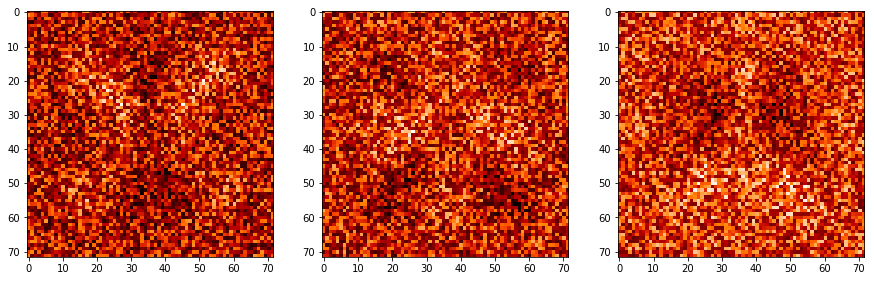

In [91]:
plot_weights(model_sgd)

## 3.2/ Visualization - Optimizer: Adam

<module 'matplotlib.pyplot' from 'C:\\Users\\dorak\\AppData\\Local\\conda\\conda\\envs\\my_root\\lib\\site-packages\\matplotlib\\pyplot.py'>

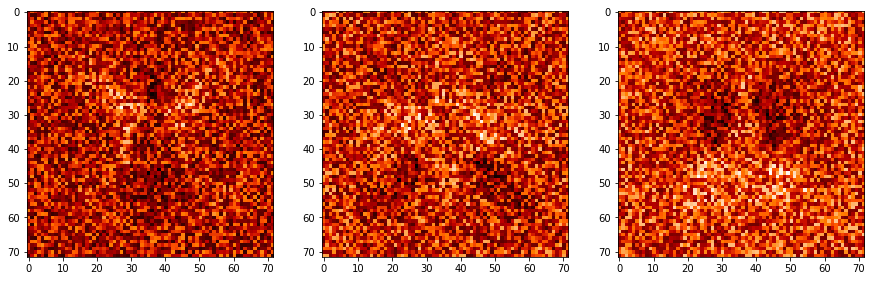

In [92]:
plot_weights(model_adam)

# 4/ A More Difficult Classification Problem

Now, the shapes are allowed to move within the images and change dimensions. Train a convolutional (not-to-)deep network on this new dataset.

In [93]:
batch_size = 32
nb_classes = 3
nb_epoch = 10

img_size = 72

lr_to_test = [0.0001, 0.001, 0.01, 0.1]

In [94]:
#Generate training data - converting Y_train to categorical
[X_train, Y_train] = generate_dataset_classification(500, 20, True)
Y_train = to_categorical(Y_train, num_classes=nb_classes)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [95]:
#Generate testing data
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [96]:
#Reshaping X sets to fit Convolutional models
X_train = np.array([x.reshape(img_size,img_size) for x in X_train])
X_test = np.array([x.reshape(img_size,img_size) for x in X_test])

In [97]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_test = X_test.reshape(X_test.shape[0], img_size, img_size, 1)

In [98]:
def free_movement_model():
    #Initializing classifier
    model = Sequential()
    
    #Adding a convolutional layer with 16 5x5 filters and 1 pooling layer that performs max pooling with a 5x5 filter
    model.add(Conv2D(16, (5,5,), activation='relu', input_shape=(img_size, img_size, 1)))
    model.add(MaxPooling2D(pool_size=5))
    
    model.add(Flatten())
    
    #Adding output layer
    model.add(Dense(nb_classes, activation='softmax'))

    return(model)

In [99]:
for lr in lr_to_test:
    model = free_movement_model()
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
    early_stopping = EarlyStopping(patience=3)
    model_training = model.fit(X_train, Y_train, 
                               batch_size=batch_size, 
                               epochs=nb_epoch,
                               verbose=1, 
                               validation_data=(X_test, Y_test),
                               callbacks=[early_stopping])
    model_testing = model.evaluate(X_test, Y_test, verbose=1)
    print('Test score:', model_testing[0])
    print('Test accuracy:', model_testing[1])

Train on 500 samples, validate on 300 samples
Epoch 1/10
500/500 [==============================] - 3s 5ms/step - loss: 0.2227 - acc: 0.3740 - val_loss: 0.2250 - val_acc: 0.3300
Epoch 2/10
500/500 [==============================] - 2s 4ms/step - loss: 0.2197 - acc: 0.3880 - val_loss: 0.2232 - val_acc: 0.3367
Epoch 3/10
500/500 [==============================] - 2s 4ms/step - loss: 0.2175 - acc: 0.3940 - val_loss: 0.2219 - val_acc: 0.3367
Epoch 4/10
500/500 [==============================] - 2s 4ms/step - loss: 0.2151 - acc: 0.3980 - val_loss: 0.2186 - val_acc: 0.3633
Epoch 5/10
500/500 [==============================] - 2s 4ms/step - loss: 0.2130 - acc: 0.4420 - val_loss: 0.2166 - val_acc: 0.3867
Epoch 6/10
500/500 [==============================] - 2s 4ms/step - loss: 0.2107 - acc: 0.4140 - val_loss: 0.2157 - val_acc: 0.3567
Epoch 7/10
500/500 [==============================] - 2s 4ms/step - loss: 0.2079 - acc: 0.4620 - val_loss: 0.2116 - val_acc: 0.4600
Epoch 8/10
500/500 [==========

### Using Best Performing Learning Rate

In [100]:
model = free_movement_model()
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, 
              loss='mean_squared_error', 
              metrics=['accuracy'])
#early_stopping = EarlyStopping(patience=3)
model_training = model.fit(X_train, Y_train, 
                           batch_size=batch_size, 
                           epochs=20,
                           verbose=1, 
                           validation_data=(X_test, Y_test))
                           #callbacks=[early_stopping])
model_testing = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', model_testing[0])
print('Test accuracy:', model_testing[1])

Train on 500 samples, validate on 300 samples
Epoch 1/20
500/500 [==============================] - 3s 5ms/step - loss: 0.2235 - acc: 0.4260 - val_loss: 0.2084 - val_acc: 0.5300
Epoch 2/20
500/500 [==============================] - 2s 4ms/step - loss: 0.1934 - acc: 0.5380 - val_loss: 0.1930 - val_acc: 0.5100
Epoch 3/20
500/500 [==============================] - 2s 4ms/step - loss: 0.1723 - acc: 0.6440 - val_loss: 0.1687 - val_acc: 0.6767
Epoch 4/20
500/500 [==============================] - 2s 4ms/step - loss: 0.1553 - acc: 0.7040 - val_loss: 0.1603 - val_acc: 0.6567
Epoch 5/20
500/500 [==============================] - 2s 4ms/step - loss: 0.1434 - acc: 0.7240 - val_loss: 0.1561 - val_acc: 0.6300
Epoch 6/20
500/500 [==============================] - 2s 4ms/step - loss: 0.1322 - acc: 0.7380 - val_loss: 0.1428 - val_acc: 0.7033
Epoch 7/20
500/500 [==============================] - 2s 4ms/step - loss: 0.1256 - acc: 0.7320 - val_loss: 0.1386 - val_acc: 0.6900
Epoch 8/20
500/500 [==========

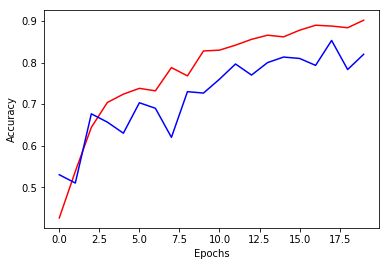

In [101]:
plt.plot(model_training.history['acc'], 'r', model_training.history['val_acc'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# 5/ A Regression Problem

The task now is to predict the image locations of the vertices of a triangle, given an image of this
triangle.

In [102]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [103]:
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

In [104]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    #Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [105]:
#Generate training set
[X_train, Y_train] = generate_dataset_regression(500, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


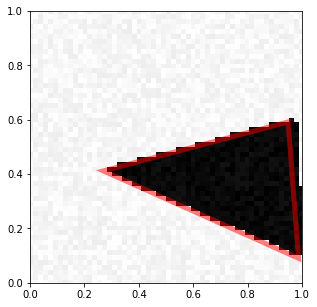

In [106]:
visualize_prediction(X_train[0], Y_train[0])

In [107]:
#Generate test set
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [108]:
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [109]:
#Defining normalization function for Y_train and Y_test

def sorting_from_center(Y):
    d_1 = np.sqrt(Y[:,0]**2+Y[:,1]**2)
    d_2 = np.sqrt(Y[:,2]**2+Y[:,3]**2)
    d_3 = np.sqrt(Y[:,4]**2+Y[:,5]**2)
    distance = np.column_stack((d_1,d_2,d_3))
    
    order = list(map(lambda i: [list(distance[i]).index(x) for x in sorted(distance[i])],range(len(distance))))
    
    x_reord = list(map(lambda i: Y[i, [k*2 for k in order[i]]], range(len(distance))))
    y_reord = list(map(lambda i: Y[i, [(k*2)+1 for k in order[i]]], range(len(distance))))

    new = np.array(list(map(lambda i : np.array((x_reord[i],y_reord[i])).T.reshape(6), range(len(distance)))))
    
    return new

In [110]:
#Applying normalization in Y_train and Y_test

Y_train=sorting_from_center(Y_train)
Y_test=sorting_from_center(Y_test)

In [111]:
def regression_model():
    model = Sequential()

    #Adding two convolutional layers with 32 and 64 5x5 filters each and 2 pooling layers 
    #that performs max pooling with a 5x5 filter
    model.add(Conv2D(32, (5,5), activation='relu', input_shape=(72, 72, 1)))
    model.add(MaxPooling2D(pool_size=(2)))
        
    model.add(Conv2D(64, (5,5), activation='relu', input_shape=(72, 72, 1)))
    model.add(MaxPooling2D(pool_size=(2)))
    
    model.add(Flatten())
    
    #1,024 neurons, with dropout regularization rate of 0.4 
    #probability of 0.4 that any given element will be dropped during training
    model.add(Dense(1024, activation='relu'))
    #model.add(Dropout(0.4))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.4))    
    
    #output layer with 6 neurons, one for each Y vector
    model.add(Dense(6, activation='linear'))

    return(model)

In [112]:
lr_to_test = [0.0001, 0.001, 0.01]

for lr in lr_to_test:
    model = regression_model()
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, 
                    loss='mean_squared_error', 
                    metrics=['accuracy']) 
    early_stopping = EarlyStopping(patience=2)
    model_training = model.fit(X_train, Y_train, 
                               batch_size=32, 
                               epochs=10,
                               verbose=1, 
                               validation_data=(X_test, Y_test),
                               callbacks=[early_stopping])
    model_testing = model.evaluate(X_test, Y_test, verbose=1)
    print('Test score:', model_testing[0])
    print('Test accuracy:', model_testing[1])

Train on 500 samples, validate on 300 samples
Epoch 1/10
500/500 [==============================] - 20s 40ms/step - loss: 0.1029 - acc: 0.3660 - val_loss: 0.0633 - val_acc: 0.4067
Epoch 2/10
500/500 [==============================] - 21s 42ms/step - loss: 0.0617 - acc: 0.4560 - val_loss: 0.0469 - val_acc: 0.5300
Epoch 3/10
500/500 [==============================] - 15s 31ms/step - loss: 0.0451 - acc: 0.5720 - val_loss: 0.0414 - val_acc: 0.5833
Epoch 4/10
500/500 [==============================] - 18s 37ms/step - loss: 0.0405 - acc: 0.6200 - val_loss: 0.0386 - val_acc: 0.6167
Epoch 5/10
500/500 [==============================] - 18s 35ms/step - loss: 0.0356 - acc: 0.6220 - val_loss: 0.0363 - val_acc: 0.6033
Epoch 6/10
500/500 [==============================] - 17s 34ms/step - loss: 0.0316 - acc: 0.6580 - val_loss: 0.0327 - val_acc: 0.6600
Epoch 7/10
500/500 [==============================] - 18s 36ms/step - loss: 0.0273 - acc: 0.6960 - val_loss: 0.0305 - val_acc: 0.6767
Epoch 8/10
500/5

### Using Best Performing Learning Rate and Increasing # of Epochs

In [113]:
model = regression_model()
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=['accuracy']) 
early_stopping = EarlyStopping(patience=2)
model_training = model.fit(X_train, Y_train, 
                           batch_size=32, 
                           epochs=20,
                           verbose=1, 
                           validation_data=(X_test, Y_test),
                           callbacks=[early_stopping])
model_testing = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', model_testing[0])
print('Test accuracy:', model_testing[1])

Train on 500 samples, validate on 300 samples
Epoch 1/20
500/500 [==============================] - 17s 35ms/step - loss: 0.9330 - acc: 0.2420 - val_loss: 0.0647 - val_acc: 0.4633
Epoch 2/20
500/500 [==============================] - 18s 36ms/step - loss: 0.0605 - acc: 0.5200 - val_loss: 0.0492 - val_acc: 0.5567
Epoch 3/20
500/500 [==============================] - 19s 37ms/step - loss: 0.0450 - acc: 0.6320 - val_loss: 0.0405 - val_acc: 0.6200
Epoch 4/20
500/500 [==============================] - 16s 32ms/step - loss: 0.0392 - acc: 0.6120 - val_loss: 0.0365 - val_acc: 0.6333
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.0350 - acc: 0.6520 - val_loss: 0.0349 - val_acc: 0.6433
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.0304 - acc: 0.6900 - val_loss: 0.0295 - val_acc: 0.7100
Epoch 7/20
500/500 [==============================] - 15s 31ms/step - loss: 0.0264 - acc: 0.7080 - val_loss: 0.0283 - val_acc: 0.7200
Epoch 8/20
500/5

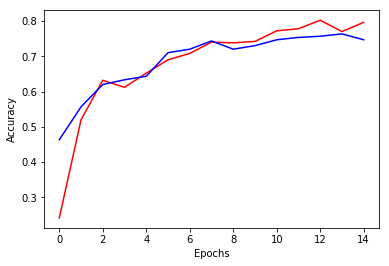

In [114]:
plt.plot(model_training.history['acc'], 'r', model_training.history['val_acc'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Testing Prediction

In [115]:
pred = model.predict(X_test)

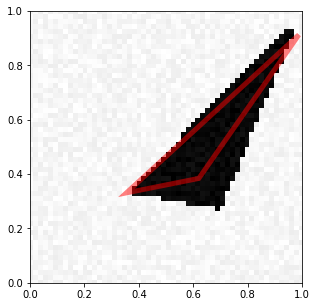

In [117]:
visualize_prediction(X_test[0], pred[0])

# 6/ Bonus Question

Implement a hourglass network for denoising. Train your network to predict a noise-free image given a noisy
image as input.

In [119]:
def generate_a_rectangle_with_noise(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    X= generate_a_drawing(figsize, U, V, noise)
    Y=generate_a_drawing(figsize, U, V, 0.0)
    return [X,Y]

def generate_a_disk_with_noise(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    X=[]
    Y=[]
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    X= generate_a_drawing(figsize, U, V, noise)
    Y=generate_a_drawing(figsize, U, V, 0.0)
    return [ X,Y]

def generate_a_triangle_with_noise(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    im2data= generate_a_drawing(figsize, U, V, 0.0)
    return [imdata, im2data]

def generate_dataset_with_noise(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        noise = np.random.randint(50)
        category = np.random.randint(3)
        if category == 0:
            [X[i], Y[i]] = generate_a_rectangle_with_noise(noise, free_location)
        elif category == 1: 
            [X[i], Y[i]] = generate_a_disk_with_noise(noise, free_location)
        else:
            [X[i], Y[i]] = generate_a_triangle_with_noise(noise, free_location)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [120]:
[X_train, Y_train] = generate_dataset_with_noise(300)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [121]:
[X_test,Y_test]= generate_dataset_with_noise(300)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [122]:
X_train = X_train.astype('float32') / 255.
Y_train = Y_train.astype('float32') / 255.

X_test = X_test.astype('float32') / 255.
Y_test = Y_test.astype('float32') / 255.

X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
Y_train = Y_train.reshape(Y_train.shape[0], 72, 72, 1)

X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)
Y_test = Y_test.reshape(Y_test.shape[0], 72, 72, 1)

In [136]:
def denoising_model():
    model=Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(72,72,1)))
    model.add(MaxPooling2D((2,2), padding='same'))
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(72,72,1)))
    model.add(MaxPooling2D((2,2), padding='same'))

    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(72,72,1)))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(72,72,1)))
    model.add(UpSampling2D((2,2)))

    model.add(Conv2D(1, (3,3), activation='relu', padding='same', input_shape=(72,72,1)))
    return(model)

In [141]:
model = denoising_model()
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
model_training = model.fit(X_train, Y_train,
                           epochs=10,
                           batch_size=64,
                           shuffle=True,
                           validation_data=(X_test, Y_test), 
                           callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])
model_testing = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', model_testing[0])
print('Test accuracy:', model_testing[1])

Train on 300 samples, validate on 300 samples
Epoch 1/10
300/300 [==============================] - 10s 33ms/step - loss: 5.1341 - acc: 0.2228 - val_loss: 3.9996 - val_acc: 0.2031
Epoch 2/10
300/300 [==============================] - 9s 31ms/step - loss: 3.6471 - acc: 0.2228 - val_loss: 3.2540 - val_acc: 0.2031
Epoch 3/10
300/300 [==============================] - 9s 31ms/step - loss: 2.8782 - acc: 0.2228 - val_loss: 2.4479 - val_acc: 0.2031
Epoch 4/10
300/300 [==============================] - 10s 33ms/step - loss: 2.1189 - acc: 0.2228 - val_loss: 1.7289 - val_acc: 0.2031
Epoch 5/10
300/300 [==============================] - 10s 34ms/step - loss: 1.4740 - acc: 0.2228 - val_loss: 1.1597 - val_acc: 0.2031
Epoch 6/10
300/300 [==============================] - 10s 32ms/step - loss: 0.9903 - acc: 0.2540 - val_loss: 0.7759 - val_acc: 0.5255
Epoch 7/10
300/300 [==============================] - 9s 31ms/step - loss: 0.7145 - acc: 0.5944 - val_loss: 0.6446 - val_acc: 0.6722
Epoch 8/10
300/300 

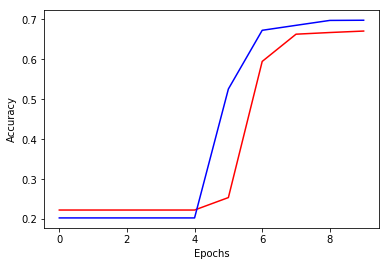

In [142]:
plt.plot(model_training.history['acc'], 'r', model_training.history['val_acc'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Testing Prediction

In [147]:
pred = np.array(model.predict(X_test))

#Reshaping prediction
pred = pred.astype('float32') / 255.
pred = pred.reshape(pred.shape[0], 72, 72, 1)

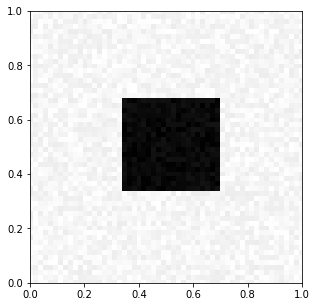

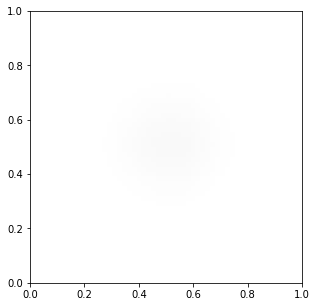

In [149]:
y = np.array([0,0,0,0,0,0])

plt.figure(figsize=(4, 2))

visualize_prediction(X_test[0],y)
visualize_prediction(pred[0],y)

After multiple trials this is the best prediction obtained. There is a lot of margin left for improvement.